In [172]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [173]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [174]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [175]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [176]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

In [177]:
def get_discount_matrix(size, rev = False, cor_supr_size=0):
    a = np.arange(size)
    if rev:
        a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    else:
        a = np.abs(a - a[np.newaxis].T)
    np.fill_diagonal(a, 0)

    if cor_supr_size > 0:
        a[:cor_supr_size] = 0
        a[:, 0:cor_supr_size] = 0
        a[-cor_supr_size:] = 0
        a[:, -cor_supr_size:] = 0

    return a

# a = get_discount_matrix(10, rev=True, cor_supr_size=2)
# a = np.array(a, dtype='float')
# # a[:, 0:2] = 0
# print(a)
# show_image(a, cmap='Greys')

In [178]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [179]:
def infer(input: ndarray, W: ndarray, iter_cnt: int):
    I = np.copy(input)

    O = np.zeros(I.size)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)

        O = O ** 2

        # inhibition
        O[np.where(O < np.mean(O))] = 0

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        # t = np.sum(O > 0)
        t = np.mean(O)
        # t = np.sum(O)

        T.append(t)

        OST.append(np.copy(O))
    
    return T, OST


- TODO: temporal W during relaxation, then update real W
- TODO: statistical (axonal) weights. Update S during relaxing? Energy is amount of active Neurons or dendrite error?
- TODO: Temperatura - increase then decrease.
- TODO: Dendrites' stats weight.
- TODO: weight decay

- TODO: associative (serotonin) weights update?

In [180]:
a = np.array([[1,2,3,4],[5,6,7,8]])
b = np.array([1,0])
a * (b>0)[np.newaxis].T

array([[1, 2, 3, 4],
       [0, 0, 0, 0]])

In [181]:
def relax(I: ndarray,
          inp_S: ndarray,
          W: ndarray,
          inp_NS: ndarray,
          NW: ndarray,
          inp_PS: ndarray,
          inp_NPS: ndarray,
          iter_cnt=100,
          ddsc=1.0,
          s_axis = 0,
          eps0 = 0.01,
          S_C: Literal['eps', 'R', None] = None,
          ):
    S = np.copy(inp_S)
    NS = np.copy(inp_NS)
    O = np.zeros(S.shape[0])

    prev_S = np.copy(inp_S)
    prev_NS = np.copy(inp_NS)
    prev_O = np.copy(O)
    prev_SO = np.zeros(S.shape)
    prev_NSO = np.zeros(NS.shape)

    SP = []
    MP = []
    CP = []
    DP = []

    OST = []

    is_break = False

    eq_cp_cnt = 0

    for iter_idx in range(iter_cnt):
        eps = (iter_cnt - iter_idx) * eps0

        # infer
        np.fill_diagonal(S, 0)
        SO = I * S
        DO = np.exp((SO - W)**2 * -20.0)
        DO *= inp_PS
        np.fill_diagonal(DO, 0)
        dO = np.sum(DO, axis=1)
        dO /= np.max(dO)
        O += dO

        # inhibition infer
        np.fill_diagonal(NS, 0)
        NSO = O * NS
        NDO = np.exp((NSO - NW)**2 * -20.0)
        NDO *= inp_NPS
        np.fill_diagonal(NDO, 0)
        dNO = np.sum(NDO, axis=1)
        dNO /= np.max(dNO)
        O -= dNO

        # inhibition
        O[np.where(O < 0)] = 0

        # threshold
        # thre = 0.5
        # O[np.where(O > thre)] = thre
        O **= 2

        # train inh stats S
        R = (np.random.rand(S.shape[0], S.shape[1]) * eps0)
        NO = O / np.max(O)
        if S_C == 'R':
            ddS = NO * I[np.newaxis].T * R
        if S_C == 'eps':
            ddS = NO * I[np.newaxis].T * eps
        else:
            ddS = NO * I[np.newaxis].T

        dNS = np.copy(ddS)

        # inh update
        NS += dNS**ddsc

        # train stats S
        dS = np.copy(ddS)

        # update
        S += dS**ddsc

        # stats
        # mask_O = (O > 0)[np.newaxis].T
        SP.append(np.sum(O))
        MP.append(np.mean(O[np.where(O > 0)]))
        CP.append(np.sum(O > 0))
        DP.append(np.sum(np.abs(SO - W) + np.abs(NSO - NW)))

        # recur
        O /= np.max(O)

        I = np.copy(O)

        max_S = np.max(S, axis=s_axis)
        if np.max(max_S) > 1:
            # print(f'{np.max(max_S)=}')
            if s_axis == 1:
                S /= max_S[np.newaxis].T
            else:
                S /= max_S
            # print(f'{np.max(S)=}')

        max_NS = np.max(NS, axis=s_axis)
        if np.max(max_NS) > 1:
            # print(f'{np.max(max_NS)=}')
            if s_axis == 1:
                NS /= max_NS[np.newaxis].T
            else:
                NS /= max_NS

        # prev
        if not is_break:
            prev_S = np.copy(S)
            prev_NS = np.copy(NS)
            prev_O = np.copy(O)
            prev_SO = np.copy(SO)
            prev_NSO = np.copy(NSO)

        # stats
        OST.append(np.copy(O))

        # break
        if iter_idx > 1 and MP[iter_idx-1] > MP[iter_idx] and MP[iter_idx-1] > MP[iter_idx - 2]:
            # break
            depth = (MP[iter_idx-1] - MP[iter_idx]) + (MP[iter_idx-1] - MP[iter_idx - 2])
            # print(f'Mean Out break: {iter_idx-1=} {depth=}')
            # break
        
        if iter_idx > 1 and DP[iter_idx-1] < DP[iter_idx] and DP[iter_idx-1] < DP[iter_idx - 2]:
            depth = (DP[iter_idx] - DP[iter_idx-1]) + (DP[iter_idx - 2] - DP[iter_idx-1])
            print(f'Err break: {iter_idx-1=} {depth=} {DP[iter_idx-1]=} {CP[iter_idx-1]=}')
            break
            # is_break = True
        
        if iter_idx > 1 and CP[iter_idx-1] == CP[iter_idx]:
            eq_cp_cnt += 1
        else:
            eq_cp_cnt = 0
        
        eq_cp = 5
        if eq_cp_cnt == eq_cp:
            print(f'CP break: {iter_idx=} {CP[iter_idx]=}')
            # break
            # is_break = True

    return prev_S, prev_NS, prev_O, prev_SO, prev_NSO, SP, MP, CP, DP, OST


In [182]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
NW = np.random.rand(O.size, I.size)

s_c = 0.01
S = np.random.rand(O.size, I.size) * s_c
NS = np.random.rand(O.size, I.size) * s_c

ps_c = 0.01
PS = np.random.rand(O.size, I.size) * ps_c
NPS = np.random.rand(O.size, I.size) * ps_c

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')

thre_S = 0.05

iter_cnt = 100 * 1

epoch_cnt = 100

eps0 = 0.0001
eps = eps0

DP = []
CP = []
SP = []
MP = []

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    for img in images[:1]:
        I = np.copy(img)
        print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

        prev_S, prev_NS, O, SO, NSO, rlx_SP, rlx_MP, rlx_CP, rlx_DP, OST = relax(I=I,
                                                                                 inp_S=S,
                                                                                 W=W,
                                                                                 inp_NS=NS,
                                                                                 NW=NW,
                                                                                 inp_PS=PS,
                                                                                 inp_NPS=NPS,
                                                                                 iter_cnt=100,
                                                                                 ddsc=1.0,
                                                                                 s_axis=0,
                                                                                 S_C=None,
                                                                                 eps0=0.001,)

        threshold = np.mean(O)

        # stats train
        ddS = O * I[np.newaxis].T * eps

        # S train
        dS = np.copy(ddS)
        dS[np.where(O <= threshold)] = 0

        # train
        dW = (SO - W) * eps
        dW[np.where(O <= threshold)] = 0

        # update
        W += dW
        # S += dS
        PS += dS

        # inh S train
        dNS = np.copy(ddS)
        dNS[np.where(O > threshold)] = 0

        # inh train
        dNW = (NSO - NW) * eps
        dNW[np.where(O > threshold)] = 0

        # inh update
        NW += dNW
        # NS += dNS
        NPS += dNS

        # stats
        DP.extend(rlx_DP)
        CP.extend(rlx_CP)
        SP.extend(rlx_SP)
        MP.extend(rlx_MP)

        # recur S
        max_S = np.max(S, axis=0)
        if np.max(max_S) > 1:
            S /= max_S

        max_NS = np.max(NS, axis=0)
        if np.max(max_NS) > 1:
            NS /= max_NS
        
        # recur dendritic S
        max_PS = np.max(PS, axis=1)
        if np.max(max_PS) > 1:
            PS /= max_PS[np.newaxis].T

        max_NPS = np.max(NPS, axis=1)
        if np.max(max_NPS) > 1:
            NPS /= max_NPS[np.newaxis].T

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')
print(f'{PS.shape=} {PS.max()=} {PS.min()=} {np.median(PS)=}')


W (784, 784) 0.9999963003196346 4.509708632749465e-06 0.498718386108925
S.shape=(784, 784) S.max()=0.00999999721574688 S.min()=1.0842819764267376e-08 np.median(S)=0.00499825713372772
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
Err break: iter_idx-1=1 depth=98655.66579837794 DP[iter_idx-1]=513630.94063372083 CP[iter_idx-1]=258
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
Err break: iter_idx-1=1 depth=101088.7920521216 DP[iter_idx-1]=509917.8920208622 CP[iter_idx-1]=197
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
Err break: iter_idx-1=1 depth=103183.91175933357 DP[iter_idx-1]=506526.7666352659 CP[iter_idx-1]=134
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
Err break: iter_idx-1=1 depth=104977.960243068 DP[iter_idx-1]=503461.3692919093 CP[iter_idx-1]=96
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
Err break: iter_idx-1=1 depth=106753.34179125022 DP[iter_idx-1]=500448.5898360076 CP[iter_idx-1]=77
I.shape=(784,) I.max()=1.0 I.min()=0.

CP[-1]=33


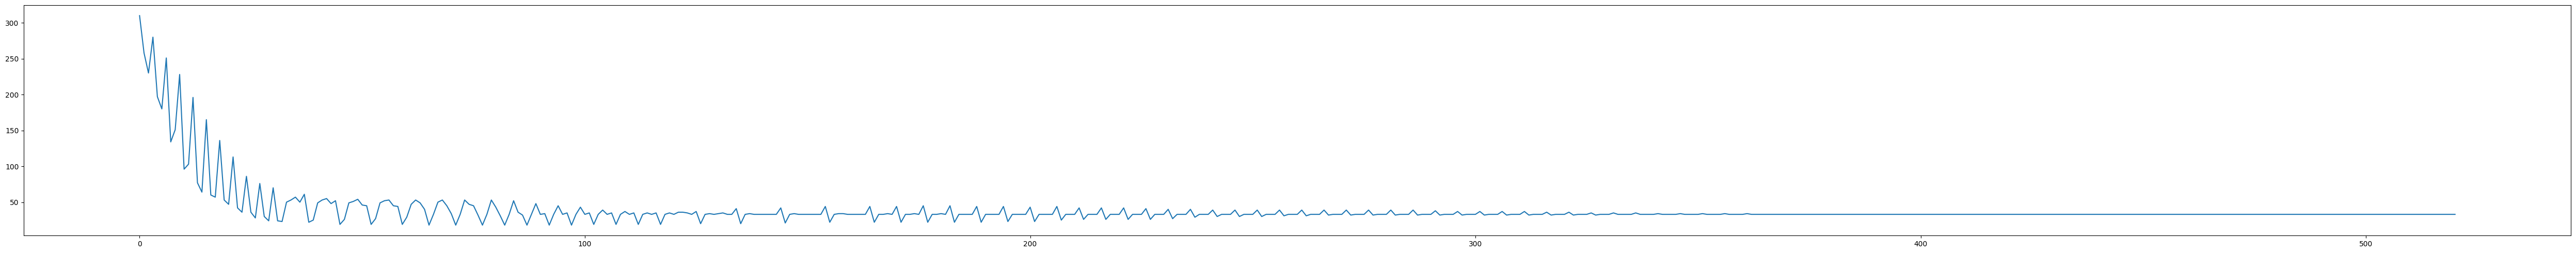

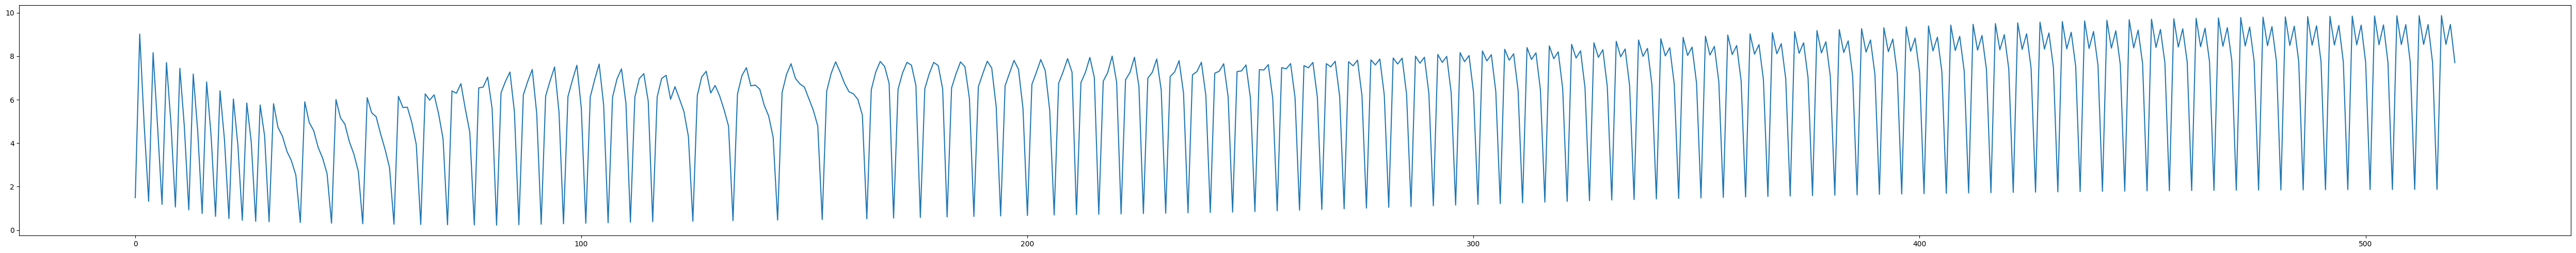

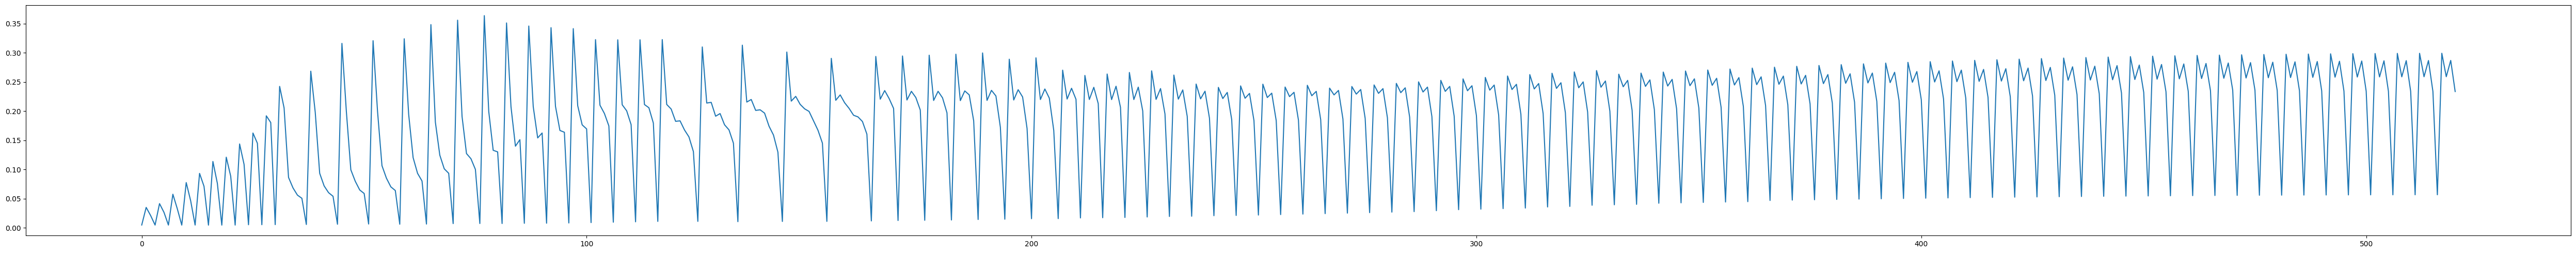

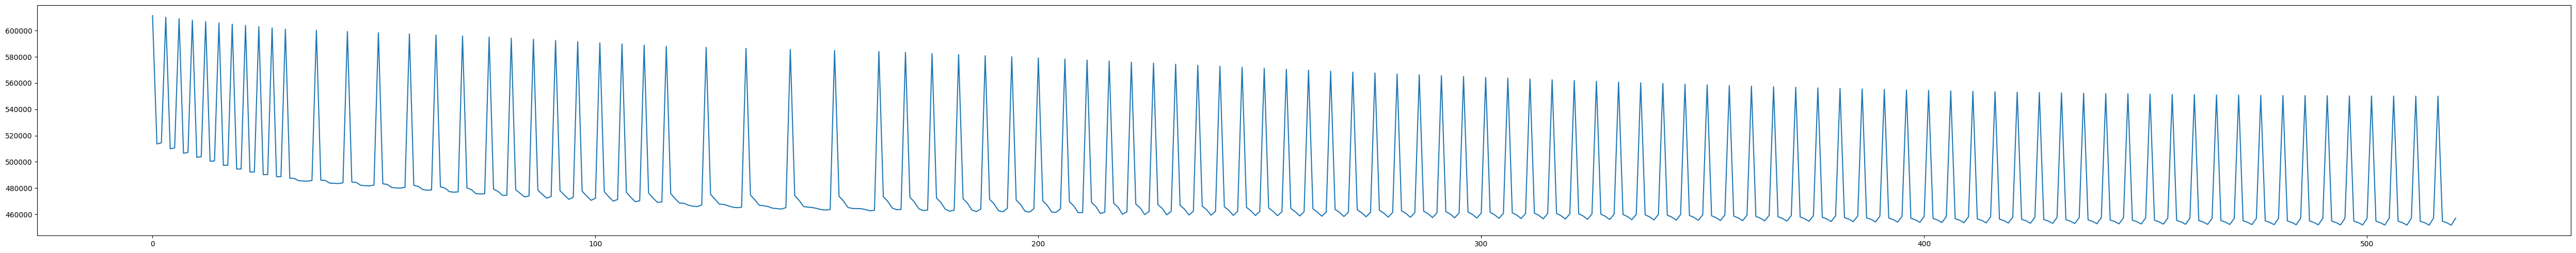

In [183]:
print(f'{CP[-1]=}')
simple_plot(T=CP)
simple_plot(T=SP)
simple_plot(T=MP)
simple_plot(T=DP)

show_image(image=OST, cmap='Greys')

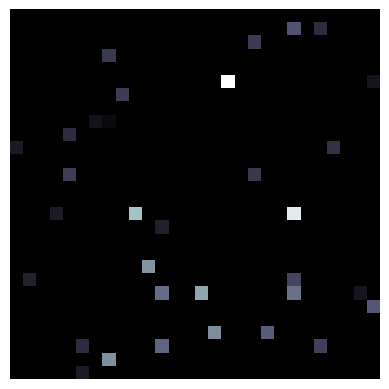

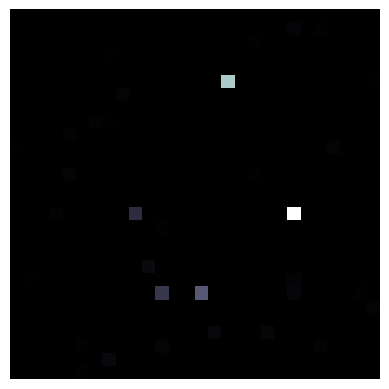

In [184]:
al = np.copy(OST[0])
al = al.reshape(img_side, img_side)
show_image(al)

al = np.copy(OST[-1])
al = al.reshape(img_side, img_side)
show_image(al)